# Plot a Map of the Martinique/St. Lucia Passage Region with glider transects

In [1]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.geoaxes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import numpy as np
import glob
import datetime
import xarray as xr
import cmocean.cm as cmo
from erddapy import ERDDAP


# Calculate rho from conductivity, temperature, pressure, lon, lat
def gsw_rho(C, T, P, lon, lat):
        # Converts Conductivity[mS/cm], temperature[°C], and pressure[dbar] to PSU
        SP = gsw.SP_from_C(C, T, P)
        # Calculates absolute salinity (g/kg) from PSU
        SA = gsw.SA_from_SP(SP, P, lon, lat)
        # in-situ density
        rho = gsw.density.rho_t_exact(SA, T, P)
        return rho,  SP



def grid_glider_data(df, varname, delta_z=.3):
    """
    Written by aristizabal. Returns a gridded glider dataset by depth and time
    """
    df.dropna(inplace=True)
    #df.dropna() # Changed to work with ru29 2020 datatset by JG
    df.drop(df[df['depth'] < .1].index, inplace=True)  # drop rows where depth is <1
    df.drop(df[df[varname] == 0].index, inplace=True)  # drop rows where the variable equals zero
    df.sort_values(by=['time', 'depth'], inplace=True)

    # find unique times and coordinates
    timeg, ind = np.unique(df.time.values, return_index=True)
    latg = df['latitude'].values[ind]
    long = df['longitude'].values[ind]
    dg = df['depth'].values
    vg = df[varname].values
    zn = np.int(np.max(np.diff(np.hstack([ind, len(dg)]))))

    depthg = np.empty((zn, len(timeg)))
    depthg[:] = np.nan
    varg = np.empty((zn, len(timeg)))
    varg[:] = np.nan

    for i, ii in enumerate(ind):
        if i < len(timeg) - 1:
            i_f = ind[i + 1]
        else:
            i_f = len(dg)
        depthi = dg[ind[i]:i_f]
        vari = vg[ind[i]:i_f]
        depthg[0:len(dg[ind[i]:i_f]), i] = depthi
        varg[0:len(vg[ind[i]:i_f]), i] = vari

    # sort time variable
    okt = np.argsort(timeg)
    timegg = timeg[okt]
    depthgg = depthg[:, okt]
    vargg = varg[:, okt]

    # Grid variables
    depthg_gridded = np.arange(0, np.nanmax(depthgg), delta_z)
    varg_gridded = np.empty((len(depthg_gridded), len(timegg)))
    varg_gridded[:] = np.nan

    for t, tt in enumerate(timegg):
        depthu, oku = np.unique(depthgg[:, t], return_index=True)
        varu = vargg[oku, t]
        okdd = np.isfinite(depthu)
        depthf = depthu[okdd]
        varf = varu[okdd]
        ok = np.asarray(np.isfinite(varf))
        if np.sum(ok) < 3:
            varg_gridded[:, t] = np.nan
        else:
            okd = np.logical_and(depthg_gridded >= np.min(depthf[ok]), depthg_gridded < np.max(depthf[ok]))
            varg_gridded[okd, t] = np.interp(depthg_gridded[okd], depthf[ok], varf[ok])

    return timegg, long, latg, depthg_gridded, varg_gridded



def get_erddap_dataset(ds_id, server, variables=None, constraints=None, filetype=None):
    """
    Returns a netcdf dataset for a specified dataset ID (or dataframe if dataset cannot be converted to xarray)
    :param ds_id: dataset ID e.g. ng314-20200806T2040
    :param variables: optional list of variables
    :param constraints: optional list of constraints
    :param filetype: optional filetype to return, 'nc' (default) or 'dataframe'
    :return: netcdf dataset
    """
    variables = variables or None
    constraints = constraints or None
    filetype = filetype or 'nc'
    #ioos_url = 'https://data.ioos.us/gliders/erddap'


    e = ERDDAP(server,
               protocol='tabledap',
               response='nc')
    e.dataset_id = ds_id
    if constraints:
        e.constraints = constraints
    if variables:
        e.variables = variables
    if filetype == 'nc':
        try:
            ds = e.to_xarray()
            ds = ds.sortby(ds.time)
        except OSError:
            print('No dataset available for specified constraints: {}'.format(ds_id))
            ds = []
        except TypeError:
            print('Cannot convert to xarray, providing dataframe: {}'.format(ds_id))
            ds = e.to_pandas().dropna()
    elif filetype == 'dataframe':
        #ds = e.to_pandas().dropna()
        ds = e.to_pandas().dropna(how='all')
    else:
        print('Unrecognized filetype: {}. Needs to  be "nc" or "dataframe"'.format(filetype))

    return ds


myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%y/%m/%d\n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')

# Load data

In [2]:
ds_id = 'ru29-20221005T1517-profile-sci-rt'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time']
gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf.columns = variables

gdf.time = pd.to_datetime(gdf.time)

gdf = gdf.sort_values(by='time')

gdf

,depth,latitude,longitude,time
0,5.199490,14.500037,-61.117111,2022-10-05 15:22:09.310000+00:00
1,6.680773,14.499983,-61.117111,2022-10-05 15:22:25.420000+00:00
2,9.096535,14.499928,-61.117111,2022-10-05 15:22:41.560000+00:00
3,11.880094,14.499874,-61.117111,2022-10-05 15:22:57.620000+00:00
4,NaN,14.499839,-61.117112,2022-10-05 15:23:08.080000+00:00
...,...,...,...,...
20557,6.064416,14.446345,-61.108437,2022-10-09 10:20:02.340000+00:00
20558,NaN,14.446375,-61.108433,2022-10-09 10:20:09.370000+00:00
20559,4.652716,14.446414,-61.108428,2022-10-09 10:20:18.390000+00:00
20560,NaN,14.446445,-61.108425,2022-10-09 10:20:25.410000+00:00


## Load Bathymetry Data

In [3]:
fname = 'https://gamone.whoi.edu/thredds/dodsC/usgs/data0/bathy/ETOPO2v2c_f4.nc'
ds_etpo = xr.open_dataset(fname)   

## Plot it up

/projects/dmcs_1/sw/packages/xroms/py38/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/projects/dmcs_1/sw/packages/xroms/py38/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


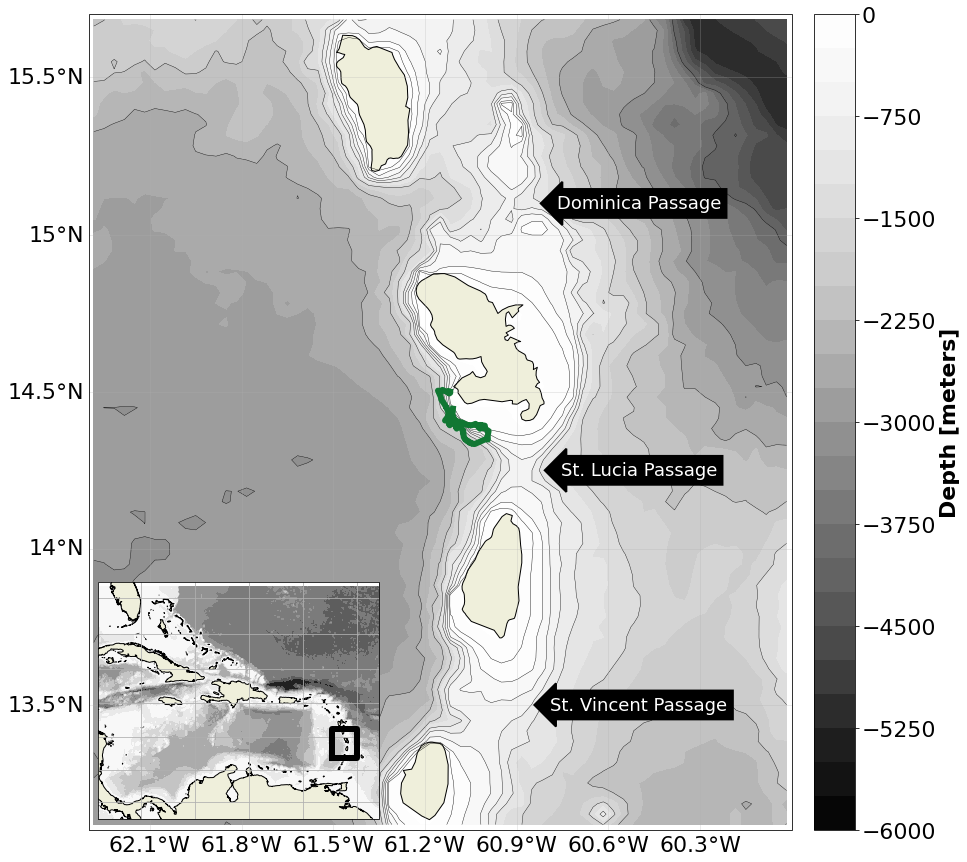

In [10]:
fig, ax = plt.subplots(figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()))

## Set lon and lat ranges
lon1 = -62.3
lon2 = -60
lat1 = 13.1
lat2 = 15.7

ax.set_extent([lon1, lon2, lat1, lat2])
## Isobars to plot
lvl = [-4000, -3000, -2500, -2000, -1500, -1000, -750, -500, -250, -100]

## Depth contours to plot
#dpth_contours = np.array([-5000,-4000,-3000,-2000, -1000,-750,-500,-250,-100,0])
dpth_contours = np.arange(-6000,1,250)
## Subset bathymetry
region = ds_etpo.sel(x=slice(lon1, lon2), y=slice(lat1, lat2))

# bathy = ax.contourf(region.x, region.y, region.z,levels=50,  cmap='Blues_r' ,  transform=ccrs.PlateCarree(), vmin=-3000, vmax=0, zorder=0)
bathy = ax.contourf(region.x, region.y, region.z,  cmap='Greys_r' ,  transform=ccrs.PlateCarree(), levels=dpth_contours, zorder=0)
ax.contour(region.x, region.y, region.z, levels= lvl, colors='k', linestyles='solid', linewidths=.4,  transform=ccrs.PlateCarree())


LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='black',
    facecolor=cfeature.COLORS['land']
)

ax.add_feature(LAND, zorder=0)

glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
glb.xlabel_style = {'size': 22}
glb.ylabel_style = {'size': 22}

ax.plot(gdf.longitude, gdf.latitude,linewidth=6, linestyle='-',transform=ccrs.PlateCarree(),color='#117733')

cbar = plt.colorbar(bathy,pad=0.02, fraction=0.0375)
cbar.set_label(label='Depth [meters]', size=22, weight='bold')
cbar.ax.tick_params(labelsize=22)

## Trying another projection
## Add a small, zoomed out map for context
## bbox_to_anchor(left, bottom, width, height)
axins = inset_axes(ax, width="40%", height="65%",
                   bbox_to_anchor=(-0.58, -0.51, 1, 1),
                   bbox_transform=ax.transAxes,
                   axes_class=cartopy.mpl.geoaxes.GeoAxes,
                   axes_kwargs=dict(map_projection=ccrs.Mercator(central_longitude=-65.5)))

## Extent of inset map
lon1_big = -84
lon2_big = -58
lat1_big = 7.5
lat2_big = 28
axins.set_extent([lon1_big, lon2_big, lat1_big, lat2_big])

## Box around actual figure region
axins.plot([lon1, lon1,  lon2, lon2, lon1] , 
                        [lat1, lat2, lat2, lat1, lat1 ], color='black',linewidth=6,  transform=ccrs.PlateCarree(), zorder=100 )
axins.add_feature(LAND, zorder=0)
axins.gridlines(linewidths=.5)

region = ds_etpo.sel(x=slice(lon1_big, lon2_big), y=slice(lat1_big, lat2_big))
## Similar to the main plot but just a tad deeper
dpth_contours = np.array([-9000,-7000,-5750,-5000,-4250,-3500,-2750,-2000, -1000,0])

## inset bathy
axins.contourf(region.x, region.y, region.z,levels=dpth_contours,  cmap='Greys_r' ,  transform=ccrs.PlateCarree(), zorder=0)

# ax.text(-61.43, 15.35, 'Dominica', transform=ccrs.Geodetic(),size=12,rotation=-65)
# ax.text(-61.10, 14.6, 'Martinique', transform=ccrs.Geodetic(),size=12,rotation=-50)
# ax.text(-61.05, 13.8, 'St. Lucia', transform=ccrs.Geodetic(),size=12,rotation=60)
# ax.text(-61.26, 13.16, 'St. Vincent', transform=ccrs.Geodetic(),size=12,rotation=60)

transform = ccrs.PlateCarree()._as_mpl_transform(ax)

ax.text(
    -60.5, 15.1, "Dominica Passage", color='white', ha="center", va="center", rotation=0, size=18,
    bbox=dict(boxstyle="larrow,pad=0.3", fc='black', ec="black", lw=2),transform=transform)

ax.text(
    -60.5, 14.25, "St. Lucia Passage", color='white', ha="center", va="center", rotation=0, size=18,
    bbox=dict(boxstyle="larrow,pad=0.3", fc='black', ec="black", lw=2),transform=transform)

ax.text(
    -60.5, 13.5, "St. Vincent Passage", color='white', ha="center", va="center", rotation=0, size=18,
    bbox=dict(boxstyle="larrow,pad=0.3", fc='black', ec="black", lw=2),transform=transform)

plt.savefig('/home/jg1200/Figures/RU29_10_2022_Martinique_Deployment_Map.png',dpi=300,facecolor='white',bbox_inches='tight')
